**COVID-19 vaccines : how do we feel about it ?**

*Eliza Ghiorghita - Romain Lesauvage*

---



# Preparation

In [ ]:
# Packages import
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from sklearn.model_selection import train_test_split
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from functools import reduce
from operator import add
import pdb
import plotly.express as px

In [ ]:
# Google drive to export/import csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Datasets recuperation : one to train the model and one with the effective tweets
!wget https://dazzling-payne-62d225.netlify.app/data/tweet_dataset.csv
!wget https://dazzling-payne-62d225.netlify.app/data/vaccination_all_tweets.csv

--2021-04-17 19:20:16--  https://dazzling-payne-62d225.netlify.app/data/tweet_dataset.csv
Resolving dazzling-payne-62d225.netlify.app (dazzling-payne-62d225.netlify.app)... 138.68.50.15, 184.72.37.151, 2604:a880:2:d0::212a:f001, ...
Connecting to dazzling-payne-62d225.netlify.app (dazzling-payne-62d225.netlify.app)|138.68.50.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8729178 (8.3M) [text/csv]
Saving to: ‘tweet_dataset.csv’

tweet_dataset.csv   100%[===================>]   8.32M  1.53MB/s    in 5.5s    

2021-04-17 19:20:22 (1.51 MB/s) - ‘tweet_dataset.csv’ saved [8729178/8729178]

--2021-04-17 19:20:22--  https://dazzling-payne-62d225.netlify.app/data/vaccination_all_tweets.csv
Resolving dazzling-payne-62d225.netlify.app (dazzling-payne-62d225.netlify.app)... 138.197.214.0, 50.18.120.10, 2604:a880:2:d0::212a:f001, ...
Connecting to dazzling-payne-62d225.netlify.app (dazzling-payne-62d225.netlify.app)|138.197.214.0|:443... connected.
HTTP request sent, 

In [ ]:
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data loading

In [ ]:
vax_tweets = pd.read_csv("vaccination_all_tweets.csv")
vax_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [ ]:
vax_tweets.shape

(39720, 16)

In [ ]:
tweets = pd.read_csv("tweet_dataset.csv")
tweets.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


In [ ]:
tweets = tweets[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'sentiment'})

In [ ]:
df_sent = tweets.dropna(subset=['sentiment'])
df_sent = df_sent[df_sent['sentiment']!='neutral']
print(len(df_sent))

18727


In [ ]:
df_sent[:5]

,text,sentiment
1,Layin n bed with a headache ughhhh...waitin o...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
5,Re-pinging @ghostridah14: why didn't you go to...,negative
7,Hmmm. http://www.djhero.com/ is down,negative


## Model preparation

In [ ]:
# we decide to modelise the sentiment by a dummy variable (0 or 1)
liste = [1 if sentiment=="positive" else 0 for sentiment in list(df_sent['sentiment'])]

In [ ]:
df_sent["sentiment_num"] = liste
df_sent[:5]

,text,sentiment,sentiment_num
1,Layin n bed with a headache ughhhh...waitin o...,negative,0
2,Funeral ceremony...gloomy friday...,negative,0
3,wants to hang out with friends SOON!,positive,1
5,Re-pinging @ghostridah14: why didn't you go to...,negative,0
7,Hmmm. http://www.djhero.com/ is down,negative,0


In [ ]:
# we split the dataset into one train dataset and one test dataset
train, test = train_test_split(df_sent, test_size = 0.2,random_state=123)

In [ ]:
train = train.reset_index()
test = test.reset_index()
test[:5]

,index,text,sentiment,sentiment_num
0,2467,Hate be late,negative,0
1,26758,My phone works! Its whack. Well good morning. ...,positive,1
2,25151,@gjr02 I can't work out if you're into diesel ...,negative,0
3,34283,"Just wanted to say, positivity is doin me good...",positive,1
4,141,@softtouchme just answered you- never learned ...,negative,0


# Baseline model

We study here a first lexicon-based model : the sentiment $S$ of sentence is based on the sentiment of each word of the sentence ($\alpha_i$) and we have then $S(t) = \mathbb{1}\{{\frac{1}{n}\sum\limits_{i=1}^n \alpha_i \geq \gamma}\}$ where
* $t$ is the tweet 
* $n$ is the number of words of the tweet
* $\alpha_i$ is the sentiment of the word $i$ calculated by counting the proportion of positive tweets in which the word is present.

## Corpus preprocessing

In [ ]:
def remove_hashtags(tokens):
    tokens = map(lambda x: x.replace('#', ''), tokens)
    return list(tokens)

def remove_url(tokens):
    tokens = filter(lambda x: "http" not in x, tokens)
    return list(tokens)

def remove_html(tokens):
    tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
    return list(tokens)

def remove_emojis(tokens):
    tokens = map(lambda x: x.encode('ascii', 'ignore').decode('ascii'), tokens)
    return list(tokens)

def remove_at(tokens):
    tokens = map(lambda x: x.replace('@', ''), tokens)
    return list(tokens)

def tokenize_url_hashtags(corpus):
    tokenizer = TweetTokenizer()
    tokenized_sentences = []
    for sample in tqdm(corpus):
        tokens_tot = []
        for sentence in sent_detector.tokenize(sample):
            tokens = tokenizer.tokenize(sentence)
            tokens = remove_url(tokens)
            tokens = remove_html(tokens)
            tokens = remove_hashtags(tokens)
            tokens = remove_emojis(tokens)
            tokens = remove_at(tokens)
            tokens = list(map(lambda x: x.lower(), tokens))
            tokens_tot+=tokens
        tokenized_sentences.append(tokens_tot)
    return tokenized_sentences

In [ ]:
train["tokens"] = tokenize_url_hashtags(train['text'])
test["tokens"] = tokenize_url_hashtags(test['text'])
train[:5]

100%|██████████| 3746/3746 [00:00<00:00, 9009.70it/s]


,index,text,sentiment,sentiment_num,tokens
0,33550,Woo CAVS. Happy Mother's Day!,positive,1,"[woo, cavs, ., happy, mother's, day, !]"
1,5763,@GatorsNow my feelings are hurt,negative,0,"[gatorsnow, my, feelings, are, hurt]"
2,8823,i want so bad to go to the mcfly's concert an...,positive,1,"[i, want, so, bad, to, go, to, the, mcfly's, c..."
3,20611,Monday morning bathing - soooo relaxing! If I ...,positive,1,"[monday, morning, bathing, -, soooo, relaxing,..."
4,33683,@AmyPredsfan Oops..too late. Already popped i...,negative,0,"[amypredsfan, oops, .., too, late, ., already,..."


In [ ]:
words = [word for phrase in train['tokens'] for word in phrase]
print(words[:5])
vocabulary = list(dict.fromkeys(words))
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))

['woo', 'cavs', '.', 'happy', "mother's"]
Nombre de mots : 234923
Taille du vocabulaire : 23811


## Sentiment matrix

In [ ]:
def sentiment_plus(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)

# les sentiments des mots appartient à 0 1. 
def mat_sentiments(corpus, vocabulaire):   
    #Initialisation
    matrice_sent = {mot:(0,0) for mot in vocabulaire}
    for index, row in corpus.iterrows():
        tweet = row['tokens']
        score = row['sentiment_num']
        for mot in tweet:
            if score == 1:
                sentiment_plus(mot, matrice_sent)
            else:
                sentiment_moins(mot,matrice_sent)
    matrice_sentiments_val = {mot:(matrice_sent[mot][0])/((matrice_sent[mot][0]+matrice_sent[mot][1]))
                          for mot in vocabulaire}
    return matrice_sentiments_val

In [ ]:
matrice_sent = mat_sentiments(train[['sentiment_num','tokens']],vocabulary)

In [ ]:
# We check the coherence of the results
print(matrice_sent['good'])
print(matrice_sent['bad'])
print(matrice_sent['.'])

0.8446937014667817
0.13099041533546327
0.49115530071977553


The word "good" has a sentiment of 0.84 whereas "bad"'s sentiment is 0.13. It 
seems normal.

We check that neutral symbol such as "." have a sentiment around 0.5 : it is the case.

## Sentiment score

In [ ]:
# The sentiment score of the sentence is the mean of the words sentiment 
def sentiments_phrase(phrase,matrice_sentiments):
    somme = 0
    n = 0
    for mot in phrase:
        if mot in matrice_sentiments.keys():
            somme += matrice_sentiments[mot]
        n += 1
    if(n!=0):
        return(somme/n)
    else:
        return 0

In [ ]:
for index, val in train.iterrows():
  phrase = val['tokens']
  score = sentiments_phrase(phrase,matrice_sent)
  train.loc[index,"pred"] = [1 if score >=0.5 else 0]

In [ ]:
train[:5]

,index,text,sentiment,sentiment_num,tokens,pred
0,33550,Woo CAVS. Happy Mother's Day!,positive,1,"[woo, cavs, ., happy, mother's, day, !]",1.0
1,5763,@GatorsNow my feelings are hurt,negative,0,"[gatorsnow, my, feelings, are, hurt]",0.0
2,8823,i want so bad to go to the mcfly's concert an...,positive,1,"[i, want, so, bad, to, go, to, the, mcfly's, c...",0.0
3,20611,Monday morning bathing - soooo relaxing! If I ...,positive,1,"[monday, morning, bathing, -, soooo, relaxing,...",1.0
4,33683,@AmyPredsfan Oops..too late. Already popped i...,negative,0,"[amypredsfan, oops, .., too, late, ., already,...",0.0


In [ ]:
for index, val in test.iterrows():
  phrase = val['tokens']
  score = sentiments_phrase(phrase,matrice_sent)
  test.loc[index,"pred"] = [1 if score >=0.5 else 0]

In [ ]:
test[:5]

,index,text,sentiment,sentiment_num,tokens,pred
0,2467,Hate be late,negative,0,"[hate, be, late]",0.0
1,26758,My phone works! Its whack. Well good morning. ...,positive,1,"[my, phone, works, !, its, whack, ., well, goo...",1.0
2,25151,@gjr02 I can't work out if you're into diesel ...,negative,0,"[gjr02, i, can't, work, out, if, you're, into,...",0.0
3,34283,"Just wanted to say, positivity is doin me good...",positive,1,"[just, wanted, to, say, ,, positivity, is, doi...",1.0
4,141,@softtouchme just answered you- never learned ...,negative,0,"[softtouchme, just, answered, you, -, never, l...",1.0


In [ ]:
tp = 0
fp = 0
for index, val in test.iterrows():
  sent = val["sentiment_num"]
  pred = val["pred"]
  if sent == 1:
    if pred == 1:
      tp += 1
    else:
      fp += 1
print(tp/(tp+fp)) # precision

0.6629944917376064


In [ ]:
isTrue = 0
tot = 0
for index, val in test.iterrows():
  sent = val["sentiment_num"]
  pred = val["pred"]
  tot += 1
  if sent == pred:
    isTrue += 1
print(isTrue/(tot)) # accuracy

0.7722904431393487


We obtain a precision of 66% and an accuracy of 77%, these are our thresholds we hope to improve with our model.

# BERT model

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 7.1MB/s 
     |████████████████████████████████| 3.3MB 34.4MB/s 
     |████████████████████████████████| 870kB 50.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=696b13de583a20db93616454a9c97ed19f06a6c850ea537fd362a918ad19dda2
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## Data preprocessing

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader

class VaccineDataset():

    def __init__(self, datasetname, maxlen, model_name='bert-base-uncased'):

        #Store the contents of the file in a pandas dataframe
        self.dataset = datasetname

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.dataset.loc[index]['text']
        label = self.dataset.loc[index]['sentiment_num']

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        if self.tokenizer.cls_token is None:
          bos_token = self.tokenizer.bos_token
        else:
          bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
          eos_token = self.tokenizer.eos_token
        else:
          eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [ ]:
train_set = VaccineDataset(datasetname = train, maxlen = 30, model_name='bert-base-uncased')
val_set = VaccineDataset(datasetname = test, maxlen = 30, model_name='bert-base-uncased')

In [ ]:
train_loader = DataLoader(train_set, batch_size = 12, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 12, num_workers = 5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# get the number of sentences
print(val_set.__len__())
# get  tokenized sentence indexed by 0 
val_set.__getitem__(0)

3746


(tensor([ 101, 5223, 2022, 2397,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 0)

In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(SentimentClassifier, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        pool = cont_reps["pooler_output"]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(pool)

        return logits


In [ ]:
sentiment_model = SentimentClassifier('bert-base-uncased')
sentiment_model = sentiment_model.to("cuda")

## Finetuning of BERT model

In [ ]:
import torch.nn as nn
import torch.optim as optim
# define the loss and optimizer 
criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(sentiment_model.parameters(), lr = 1e-5)

In [ ]:
import pdb
def train(model, criterion, opti, train_loader, val_loader, max_eps=1, gpu=False, print_every=1,validate_every=1, break_training_after=None):
    if gpu:
      model = model.to("cuda")
    for ep in range(max_eps):
        
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits = model(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())
            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()
            if (it + 1) % print_every == 0:
                accuracy = torch.sum((logits>0).int().squeeze(1)==labels)/float(labels.size(0))
                print("Iteration {} of epoch {} complete. Loss : {}, Accuracy {} ".format(it+1, ep+1, loss.item(),accuracy))
            if break_training_after is not None and it>break_training_after:
              print("Early breaking : did not cover a full epoch but only {} iteration ".format(it))
              break
        if ep % validate_every==0:
          # evaluation on the validation set 
          n_batch_validation = 0
          loss_validation = 0
          accuracy_validation = 0
          for it, (seq, attn_masks, labels) in enumerate(val_loader):            
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits_val = model(seq, attn_masks)
            n_batch_validation+=1
            #Computing loss
           
            _loss = float(criterion(logits_val.squeeze(-1), labels.float()))
            _accu = float(torch.sum((logits_val>0).int().squeeze(1)==labels)/float(labels.size(0)))
           
            loss_validation += _loss
            accuracy_validation += _accu
          print("EVALUATION Validation set : mean loss {} n mean accuracy {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))

In [ ]:
train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=5, print_every=100, gpu=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 100 of epoch 1 complete. Loss : 0.2080153226852417, Accuracy 1.0 
Iteration 200 of epoch 1 complete. Loss : 0.1778271645307541, Accuracy 1.0 
Iteration 300 of epoch 1 complete. Loss : 0.3820924162864685, Accuracy 0.8333333730697632 
Iteration 400 of epoch 1 complete. Loss : 0.09157603979110718, Accuracy 1.0 
Iteration 500 of epoch 1 complete. Loss : 0.22953712940216064, Accuracy 0.9166666865348816 
Iteration 600 of epoch 1 complete. Loss : 0.04371460899710655, Accuracy 1.0 
Iteration 700 of epoch 1 complete. Loss : 0.4175238013267517, Accuracy 0.9166666865348816 
Iteration 800 of epoch 1 complete. Loss : 0.6179613471031189, Accuracy 0.8333333730697632 
Iteration 900 of epoch 1 complete. Loss : 0.13197758793830872, Accuracy 0.9166666865348816 
Iteration 1000 of epoch 1 complete. Loss : 0.23055855929851532, Accuracy 0.8333333730697632 
Iteration 1100 of epoch 1 complete. Loss : 0.08737066388130188, Accuracy 0.9166666865348816 
Iteration 1200 of epoch 1 complete. Loss : 0.013472

## Model applied to our dataset

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  tweet = []
  predictions = []
  prediction_probs = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d[0].cuda()
      attention_mask = d[1].cuda()
      outputs = model(
        input_ids,
        attention_mask
      )
      out = torch.sigmoid(outputs.squeeze(-1))
      tweet.extend(input_ids)
      predictions.append(out >= 0.5)
      prediction_probs.append(out)
  return tweet, predictions, prediction_probs

In [ ]:
vax_tweets['sentiment_num'] = ''
vax_tweets['sentiment_prob'] = ''

In [ ]:
vax_set = VaccineDataset(datasetname = vax_tweets, maxlen = 30, model_name='bert-base-uncased')
vax_loader = DataLoader(vax_set, batch_size = 1, num_workers = 5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
liste = get_predictions(sentiment_model, vax_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
val = liste[1]
val_prob = liste[2]

In [ ]:
val_num = [1 if valeur else 0 for valeur in val]

(array([17085.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22635.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

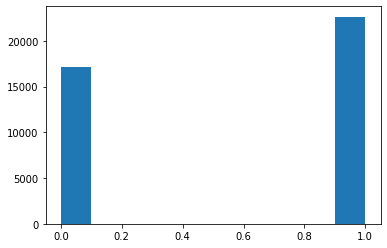

In [ ]:
import matplotlib.pyplot as plt
plt.hist(val_num)

In [ ]:
vax_tweets['sentiment_num'] = val_num
vax_tweets['sentiment_prob'] = val_prob

## Results

In [ ]:
vax_tweets['date'] = pd.to_datetime(vax_tweets['date'], errors='coerce').dt.date
timeline = vax_tweets.groupby(['date', 'sentiment_num']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

# Plot results
import plotly.express as px
fig = px.line(timeline, x='date', y='tweets', color='sentiment_num', category_orders={'sentiment': ['0','1']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

We compare the number of tweets positive and negative but it is difficult to say something. We decide to look at the positive tweets proportion among time.

In [ ]:
dates = list(timeline['date'].unique())

In [ ]:
timeline_pos = []
for date in dates:
  pos = list(timeline[timeline["date"]==date]['tweets'])
  timeline_pos.append([date,pos[1]/(pos[0]+pos[1])])

In [ ]:
tl = pd.DataFrame(timeline_pos,columns=['date','sentiment'])

In [ ]:
fig = px.line(tl, x='date', y='sentiment',
             title='Timeline showing ratio of positive tweets about COVID-19 vaccines')
fig.show()

We observe some peaks (positive or negative) on some dates but it can be explained :

* **December 20th** : several countries in EU decide to close their boarders with the UK because of the suspicion of English variant. (negative peek)

* **January 3rd** : UK announced a new lockdown due to the variant. (negative peek)

* **February 6th** : worries about variants in NYC. (negative peek)

* **Since February** : improvment due the generalization of the vaccination in the world. (positive trend)

(array([12918.,  1480.,  1031.,   837.,   819.,   750.,   918.,  1182.,
         2122., 17663.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

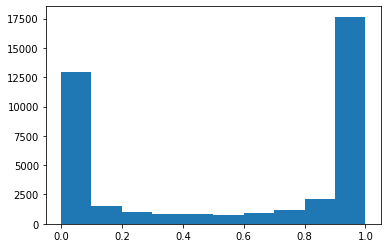

In [ ]:
plt.hist(vax_tweets['sentiment_prob'].astype('float'),bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

We observe that the sentiment seems very polarized but also that there is some sentiment around 0.5, so we decide to create a new category "neutral" for sentiments between 0.3 and 0.7.

In [ ]:
liste_prob = vax_tweets['sentiment_prob'].astype(float)
sent = ["positif" if val >= 0.7 else "negatif" if val <= 0.3 else "neutre" for val in liste_prob]

In [ ]:
vax_tweets['new_sent'] = sent

In [ ]:
#vax_tweets.to_csv('/content/drive/MyDrive/NLP/vax_with_neutral.csv')

In [ ]:
vax_tweets['date'] = pd.to_datetime(vax_tweets['date'], errors='coerce').dt.date
timeline = vax_tweets.groupby(['date', 'new_sent']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

# Plot results
import plotly.express as px
fig = px.line(timeline, x='date', y='tweets', color='new_sent', category_orders={'sentiment': ['positif','negatif','neutre']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [ ]:
dates = list(timeline['date'].unique())
timeline_neutre = []
timeline_pos = []
timeline_neg = []
for date in dates:
  pos = list(timeline[timeline["date"]==date]['tweets'])
  timeline_pos.append([date,pos[2]/(pos[0]+pos[1]+pos[2])])
  timeline_neutre.append([date,pos[1]/(pos[0]+pos[1]+pos[2])])
  timeline_neg.append([date,pos[0]/(pos[0]+pos[1]+pos[2])])

In [ ]:
tot = []
for (a,b,c) in zip(timeline_neg,timeline_neutre,timeline_pos):
  tot += [a[1],b[1],c[1]]

In [ ]:
timeline['sent_ratio'] = tot

In [ ]:
fig = px.line(timeline, x='date', y='sent_ratio', color='new_sent', category_orders={'sentiment': ['positif','negatif','neutre']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

The trend is the same as before, the dates of peeks are the same with same exaplanation

In [ ]:
tl = pd.DataFrame(timeline_pos,columns=['date','new_sent'])

In [ ]:
fig = px.line(tl, x='date', y='new_sent',
             title='Timeline showing ratio of positive tweets about COVID-19 vaccines')
fig.show()

# Typology of vaccines

In [ ]:
#Read the file
df = pd.read_csv('vaccination_all_tweets.csv')
print(len(df))

39720


In [ ]:
cleaned_df=tokenize_url_hashtags(df.text.array)
print(cleaned_df[2])

100%|██████████| 39720/39720 [00:05<00:00, 6640.82it/s]

['coronavirus', 'sputnikv', 'astrazeneca', 'pfizerbiontech', 'moderna', 'covid_19', 'russian', 'vaccine', 'is', 'created', 'to', 'last', '2-4', 'years', '']


## First classification, using basic typology

In [ ]:
T1=['sinovac', 'sinofarm', 'covaxin']
T2=['pfizerbiontech', 'moderna']
T3=['astrazeneca', 'sputnikv', 'johnson']
T4=['novavax', 'sanofi']

In [ ]:
#Detect if the text reffers to a certain type of vaccine
def type_vaccine(liste,T):
    typevac=False
    for mot in liste:
        if mot in T:
            typevac=True
    return(typevac)

In [ ]:
#'Categ_vaccin' : column indicating if the tweet reffers to a specific type of vaccine, to several types or to none
n=len(df)
tv1=[False]*n
tv2=[False]*n
tv3=[False]*n
tv4=[False]*n
t=["General"]*n
for i in range(n) : 
    tv1[i]=type_vaccine(cleaned_df[i], T1)
    tv2[i]=type_vaccine(cleaned_df[i], T2)
    tv3[i]=type_vaccine(cleaned_df[i], T3)
    tv4[i]=type_vaccine(cleaned_df[i], T4)
    if (tv1[i]+tv2[i]+tv3[i]+tv4[i]==1):
        if (tv1[i]==1):
            t[i]="Inactiv"
        elif (tv2[i]==1):
            t[i]="ARNmsg"
        elif (tv3[i]==1):
            t[i]="Viral"
        else :
            t[i]="Protein"
    elif (tv1[i]+tv2[i]+tv3[i]+tv4[i]==0):
        t[i]="None"
    else:
        t[i]="More than one"
df['categ_vaccin']=t

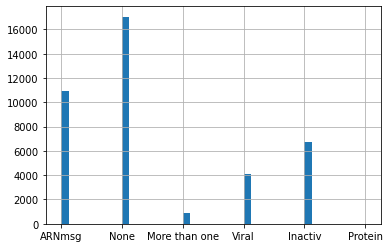

In [ ]:
%matplotlib inline
df.categ_vaccin.hist(bins=40)

In [ ]:
df.categ_vaccin.value_counts()

None             17044
ARNmsg           10938
Inactiv           6753
Viral             4085
More than one      876
Protein             24
Name: categ_vaccin, dtype: int64

We observe that a lot of tweets have "None" classification, it's bad.

In [ ]:
#Example of missclassification (if 'pfizer' instead of 'pfizerbiontech'=> not recognised)
mycolumns = ['text','categ_vaccin']
with pd.option_context('display.max_colwidth', None):
    display(df[mycolumns].iloc[57,:])

text            Members of the @teamsters delivered the first #COVID19Vaccine this morning\n#teamsters\n#UPS\n#COVID19 \n#Pfizer… https://t.co/Ms3N1s9OES
categ_vaccin                                                                                                                                         None
Name: 57, dtype: object

So now let's improve the classification by enriching the typology

## Word embedding in order to enrich the initial typology

In [ ]:
from gensim.models import word2vec
from multiprocessing import cpu_count
cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))
print("Training our model")

The virtual instance has 2 cpus, that will be used to train the word2vec model
Training our model


In [ ]:
vac = word2vec.Word2Vec(cleaned_df, size=500, window=5, min_count=3, workers=cpu)
vac.train(cleaned_df, total_examples=len(cleaned_df), epochs=10)

(5216479, 7506120)

In [ ]:
def closest_to(w, n=10):
    if w in vac.wv:
      closest_ws =[w[0] for w in vac.wv.most_similar(w, topn=n)]
      print("According to our database, the closest {}, words to \"{}\" " 
      "are: \n {}".format( n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary")

In [ ]:
vac.wv.most_similar('moderna')

[('moderna_tx', 0.5068925619125366),
 ('johnsonandjohnson', 0.4376550614833832),
 ('biontech', 0.4154750406742096),
 ('oxfordastrazeneca', 0.4080994427204132),
 ("moderna's", 0.4035710096359253),
 ('joy', 0.3997988998889923),
 ('pfizervaccine', 0.3985365331172943),
 ('pfizerbiontech', 0.39505377411842346),
 ('complete', 0.3864707350730896),
 ('vaccinesafetyadvocate', 0.37450194358825684)]

In [ ]:
#As a reminder
T1=['sinovac', 'sinopharm', 'covaxin']
T2=['pfizerbiontech', 'moderna']
T3=['astrazeneca', 'sputnikv', 'johnson']
T4=['novavax', 'sanofi']

In [ ]:
T2.extend(['modernavaccine','mrna', "pfizer's", "pfizer-biontech", "phizer","pfzier", "moderna's","moderna_tx", "biontech"])
T3.extend(["johnsonandjohnson","oxfordastrazeneca"])

In [ ]:
T3.extend(["astrazenaca","astrazenecavaccine","az","zenica","zeneca","oxford-astrazeneca", "sputnik","sputnik-v", "johnson's", 'russian', 'russia', "russia's", 'covishield'])
T2.extend(['pfizervaccine',"pfizer"])

In [ ]:
T3.extend(["astrazeneka","jnj", "janssen", 'jansen',"johnsonjohnson" ])
T4.extend(['merck','novovax'])
T2.extend(['pfizervaccine',"pfizer", 'pfizer_biontech'])
T1.extend(["sinopharm's","sinovac's",'gsk',"sinovac-made","chinese",'macao',"china's",'beijing', "coronavac","bharatbiotech","india's",'seruminstindia', 'madeinindia',"india", 'narendramodi','modi', 'mohfw_india'])

In [ ]:
#Check the results with this second typology
n=len(df)
tv1=[False]*n
tv2=[False]*n
tv3=[False]*n
tv4=[False]*n
t=["General"]*n
for i in range(n) : 
    tv1[i]=type_vaccine(cleaned_df[i],T1)
    tv2[i]=type_vaccine(cleaned_df[i],T2)
    tv3[i]=type_vaccine(cleaned_df[i],T3)
    tv4[i]=type_vaccine(cleaned_df[i],T4)
    if (tv1[i]+tv2[i]+tv3[i]+tv4[i]==1):
        if (tv1[i]==1):
            t[i]="Inactiv"
        elif (tv2[i]==1):
            t[i]="ARNmsg"
        elif (tv3[i]==1):
            t[i]="Viral"
        else :
            t[i]="Protein"
    elif (tv1[i]+tv2[i]+tv3[i]+tv4[i]==0):
        t[i]="None"
    else:
        t[i]="More than one"
df['categ_vaccin2']=t

(array([[1.0938e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.7044e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         8.7600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.0850e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         6.7530e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4000e+01],
        [1.1829e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0017e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.3250e+03, 0.0000e+00, 

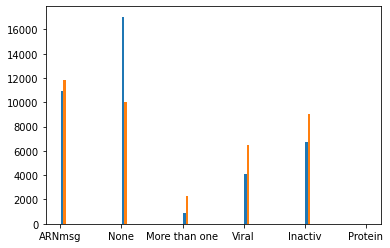

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([df['categ_vaccin'], df['categ_vaccin2']], bins=50, label=['typologie1', 'typologie2'])

In [ ]:
df.categ_vaccin2.value_counts()

ARNmsg           11829
None             10017
Inactiv           9054
Viral             6478
More than one     2325
Protein             17
Name: categ_vaccin2, dtype: int64

Big improvment : half of the "None" vaccines in the previous typology are now assigned to one of our types.

### Average embedding - by typology

In [ ]:
TC3=T1
TC3.extend(T2)
TC3.extend(T4)
TC2=T1
TC2.extend(T3)
TC2.extend(T4)
TC1=T2
TC1.extend(T3)
TC1.extend(T4)
TC4=T1
TC4.extend(T2)
TC4.extend(T3)

In [ ]:
#When introducing only a positive contraint, score are relatively high, but the words similar to T1 and T2 are quite the same
vac.wv.most_similar(positive=T1)

[('polyethyleneglycol', 0.7574619054794312),
 ('dictaturesanitaire', 0.7201043367385864),
 ('single-dose', 0.7143621444702148),
 ('seeker', 0.7009153962135315),
 ('grundrechte', 0.6934678554534912),
 ('asianlivesmatter', 0.688237190246582),
 ('esreicht', 0.6832340955734253),
 ('covid19usa', 0.6817169189453125),
 ('jnjnews', 0.6784499883651733),
 ('biontech_group', 0.6736606359481812)]

In [ ]:
vac.wv.most_similar(positive=T2)

[('polyethyleneglycol', 0.7364055514335632),
 ('jandj', 0.703313410282135),
 ('biontech_group', 0.6886601448059082),
 ('grundrechte', 0.6878188848495483),
 ('johnsonandjohnsonvaccine', 0.6871811747550964),
 ('dictaturesanitaire', 0.6836273074150085),
 ('single-dose', 0.6815540790557861),
 ('esreicht', 0.6800119876861572),
 ('seeker', 0.6680387258529663),
 ('jnjnews', 0.665838360786438)]

In [ ]:
#When introducing a positive AND a negative contraint, score are highly diminshed and doesn't seem right
vac.wv.most_similar(positive=T3, negative=T2)

[('minis', 0.4843898117542267),
 ('tafrishaala', 0.48294514417648315),
 ('suspects', 0.47655820846557617),
 ("nation's", 0.4675544500350952),
 ('prime', 0.33205971121788025),
 ('nivedita', 0.3250318765640259),
 ('waited', 0.32467231154441833),
 ('repub', 0.3239045739173889),
 ('home', 0.2951744794845581),
 ('asks', 0.2858717143535614)]

In [ ]:
vac.wv.most_similar(positive=T3, negative=TC3)

[('suspects', 0.48060476779937744),
 ("nation's", 0.3981373906135559),
 ('tafrishaala', 0.3554260730743408),
 ('minis', 0.3467510938644409),
 ('quidangen', 0.31925955414772034),
 ('went', 0.31595712900161743),
 ('nivedita', 0.30980440974235535),
 ('marketers', 0.30604198575019836),
 ('home', 0.2926156222820282),
 ('see', 0.27947309613227844)]

### Trying the same thing only on the hashtags

In [ ]:
import re
hash_prog = re.compile('#')
df1 = df.drop_duplicates('text')
df1['minuscules']=df1['text'].apply(lambda x: x.lower())
ntype = 'hashtags'
df1[ntype] = df1['minuscules'].apply(lambda x: len(hash_prog.split(x))-1).array
df1[ntype].head()

regex = "#(\w+)"
df1['hashtag_man'] = df1['minuscules'].apply(lambda x: re.findall(regex, x)).array
arrh=df1['minuscules'].apply(lambda x: re.findall(regex, x)).array
df1['hashtag_man'].head()
DictHashtags = reduce(add, arrh)
print(DictHashtags[3])
len(set(DictHashtags))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

astrazeneca


7912

In [ ]:
hasht = word2vec.Word2Vec(arrh, size=500, window=5, min_count=3, workers=cpu)
hasht.train(arrh, total_examples=len(arrh), epochs=10)

(299212, 744460)

In [ ]:
hasht.wv.most_similar('moderna') #Scores are much higher

[('pfizerbiontech', 0.9353529810905457),
 ('pfizercovidvaccine', 0.92970871925354),
 ('covidvac', 0.9275126457214355),
 ('pfizervaccine', 0.9252889752388),
 ('johnsonandjohnson', 0.9215212464332581),
 ('vaccineswork', 0.9171911478042603),
 ('oxfordastrazeneca', 0.912535548210144),
 ('1', 0.9109129309654236),
 ('vaccinessavelives', 0.9104799032211304),
 ('2', 0.9076151847839355)]

In [ ]:
hasht.wv.most_similar(positive=["oxford",'astrazeneca','astrazenecavaccine','johnson',"johnsonandjohnsonvaccine",'jandj','janssen'], negative=['moderna','pfizerbiontech','pfizer'])

[('israel', 0.988615870475769),
 ('slovaks', 0.9853893518447876),
 ('dollypartonvaccine', 0.9806027412414551),
 ('bigpharma', 0.9800355434417725),
 ('goodnews', 0.9789871573448181),
 ('brexit', 0.9771125316619873),
 ('vaccinations', 0.9768474698066711),
 ('fundamental', 0.9747326374053955),
 ('astrazeneka', 0.9741049408912659),
 ('pfizer_biontech', 0.9736347198486328)]

In [ ]:
hasht.wv.most_similar(positive=['moderna','modernavaccine','mrna', 'pfizerbiontech','pfizer', 'biontech', 'phizer'],negative=["oxford",'astrazeneca','astrazenecavaccine','johnson',"johnsonandjohnsonvaccine",'jandj','janssen'])

[('flybhaarathinternational', 0.08001767098903656),
 ('vaccinated', 0.05667128413915634),
 ('sandiegocounty', 0.03992065414786339),
 ('pfizercovidvaccine', 0.035539425909519196),
 ('1', 0.03489479795098305),
 ('ndtvexclusive', 0.028033098205924034),
 ('biontechleaks', 0.027339862659573555),
 ('vaccineswork', 0.02344806119799614),
 ('getvaccinated', 0.023033447563648224),
 ('2', 0.02026567980647087)]

The embedding works better (higher scores for T3), but we cannot use the same typology, as there are fewer words. 
So we prefer to stay on the text corpus, for the embedding, and try a last type of classification

### Average embedding

In [ ]:
#Compute an average score
def score(word,T):
    len=0
    sum=0
    for i in T :
        sum+=vac.wv.similarity(word,i)
        len=len+1
    if (len!=0):
        score=sum/len
    else :
        score=0
    return score
#Associate an average score at every text
def avg_embedding(phrase,T):
    return(sum(score(w, T) for w in phrase if w in vac.wv))

In [ ]:
t=["General"]*n
for i in range(n):
    X=cleaned_df[i]
    m1=avg_embedding(X,T1)
    m2=avg_embedding(X,T2)
    m3=avg_embedding(X,T3)
    m4=avg_embedding(X,T4)
    maximum=max(m1,m2,m3,m4)
    if (maximum!=0):
        if (maximum==m1):
            t[i]="Inactiv"
        elif (maximum==m2):
             t[i]="ARNmsg"
        elif (maximum==m3):
             t[i]=="Viral"
        else :
            t[i]=="Protein"
df['categ_vaccin3']=t         

(array([[1.1829e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0017e+04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.3250e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         6.4780e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0540e+03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.3820e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 

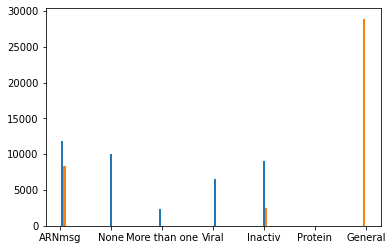

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([df['categ_vaccin2'], df['categ_vaccin3']], bins=50, label=['typologie2', 'typologie3'])

The best typology is the second one, that is the one we decide to keep for further analysis.

In [ ]:
#df.to_csv(r'data\vax_classif.csv', index = False)

### Descriptive statistics

In [ ]:
df.groupby("categ_vaccin2")["retweets"].agg([np.mean, np.std])

,mean,std
categ_vaccin2,,
ARNmsg,1.341534,23.202218
Inactiv,5.222112,50.575273
More than one,1.901505,17.034546
None,2.212738,22.083150
Protein,0.176471,0.392953
Viral,5.081352,37.999411


Tweets about inactiv and viral vaccines (such as AZ) have more retweets than other, surely because they are more controversial so people expect to have more information about them.

# Timeline evolution for different types of vaccines

In [ ]:
!wget https://dazzling-payne-62d225.netlify.app/data/vax_with_neutral.csv

--2021-04-17 20:23:14--  https://dazzling-payne-62d225.netlify.app/data/vax_with_neutral.csv
Resolving dazzling-payne-62d225.netlify.app (dazzling-payne-62d225.netlify.app)... 50.18.120.10, 138.68.235.89, 2604:a880:2:d0::212a:f001, ...
Connecting to dazzling-payne-62d225.netlify.app (dazzling-payne-62d225.netlify.app)|50.18.120.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17696870 (17M) [text/csv]
Saving to: ‘vax_with_neutral.csv’

vax_with_neutral.cs 100%[===================>]  16.88M  1.25MB/s    in 14s     

2021-04-17 20:23:28 (1.24 MB/s) - ‘vax_with_neutral.csv’ saved [17696870/17696870]



In [ ]:
vax_tweets = pd.read_csv('vax_with_neutral.csv')
vax_tweets.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,6,7,8,9,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(39720, 20)

In [ ]:
vax_tweets = df[['id','categ_vaccin2']].merge(vax_tweets,on=['id'],how='inner')

In [ ]:
vax_tweets['categ_vaccin2'].value_counts()

ARNmsg           1850
None             1810
Viral            1736
Inactiv          1106
More than one     448
Protein             2
Name: categ_vaccin2, dtype: int64

In [ ]:
arn = vax_tweets[vax_tweets['categ_vaccin2']=='ARNmsg']
viral = vax_tweets[vax_tweets['categ_vaccin2']=='Viral']
inact = vax_tweets[vax_tweets['categ_vaccin2']=='Inactiv']

arn['date'] = pd.to_datetime(arn['date'], errors='coerce').dt.date
viral['date'] = pd.to_datetime(viral['date'], errors='coerce').dt.date
inact['date'] = pd.to_datetime(inact['date'], errors='coerce').dt.date

timeline1 = arn.groupby(['date', 'new_sent']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
timeline2 = viral.groupby(['date', 'new_sent']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
timeline3 = inact.groupby(['date', 'new_sent']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

## MRNA

(ARN messager in French)

In [ ]:
dates = list(timeline1['date'].unique())
timeline_pos1 = []
for date in dates:
  pos = list(timeline1[timeline1["date"]==date]['tweets'])
  try:
    timeline_pos1.append([date,pos[2]/(pos[0]+pos[1]+pos[2])])
  except:
    timeline_pos1.append([date,0.5])

## Viral

In [ ]:
dates = list(timeline2['date'].unique())
timeline_pos2 = []
for date in dates:
  pos = list(timeline2[timeline2["date"]==date]['tweets'])
  try:
    timeline_pos2.append([date,pos[2]/(pos[0]+pos[1]+pos[2])])
  except:
    timeline_pos2.append([date,0.5])

## Inactiv

In [ ]:
dates = list(timeline3['date'].unique())
timeline_pos3 = []
for date in dates:
  pos = list(timeline3[timeline3["date"]==date]['tweets'])
  try:
    timeline_pos3.append([date,pos[2]/(pos[0]+pos[1]+pos[2])])
  except:
    timeline_pos3.append([date,0.5])

## Comparison

In [ ]:
t1 = pd.DataFrame(timeline_pos1,columns=['date','new_sent'])
t1['type'] = 'MRNA'
t2 = pd.DataFrame(timeline_pos2,columns=['date','new_sent'])
t2['type'] ='VIRAL'
t3 = pd.DataFrame(timeline_pos3,columns=['date','new_sent'])
t3['type'] = 'INACTIV'

In [ ]:
tl = pd.concat([t1,t2,t3])

In [ ]:
fig = px.line(tl, x='date', y='new_sent', color='type',
             title='Timeline showing sentiment of tweets about COVID-19 vaccines according to their type')
fig.show()

Whereas MRNA vaccines are related to a positive, steady sentiment, the attitude for viral and inactive vaccine is more unstable and dependent on the news (for example, debates around thrombosis in relation to AstraZaeneca vaccine's effects).